In [1]:
import numpy as np
import pandas as pd
import ssms
# import pytensor 
# import pytensor.tensor as pt


In [2]:
list(ssms.config.model_config.keys())

['ddm',
 'ddm_st',
 'ddm_truncnormt',
 'ddm_rayleight',
 'ddm_sdv',
 'ddm_par2',
 'ddm_par2_no_bias',
 'ddm_par2_conflict_gamma_no_bias',
 'ddm_par2_angle_no_bias',
 'ddm_par2_weibull_no_bias',
 'ddm_seq2',
 'ddm_seq2_no_bias',
 'ddm_seq2_conflict_gamma_no_bias',
 'ddm_seq2_angle_no_bias',
 'ddm_seq2_weibull_no_bias',
 'ddm_mic2_adj',
 'ddm_mic2_adj_no_bias',
 'ddm_mic2_adj_conflict_gamma_no_bias',
 'ddm_mic2_adj_angle_no_bias',
 'ddm_mic2_adj_weibull_no_bias',
 'ddm_mic2_ornstein',
 'ddm_mic2_ornstein_no_bias',
 'ddm_mic2_ornstein_no_bias_no_lowdim_noise',
 'ddm_mic2_ornstein_conflict_gamma_no_bias',
 'ddm_mic2_ornstein_conflict_gamma_no_bias_no_lowdim_noise',
 'ddm_mic2_ornstein_angle_no_bias',
 'ddm_mic2_ornstein_angle_no_bias_no_lowdim_noise',
 'ddm_mic2_ornstein_weibull_no_bias',
 'ddm_mic2_ornstein_weibull_no_bias_no_lowdim_noise',
 'ddm_mic2_leak',
 'ddm_mic2_leak_no_bias',
 'ddm_mic2_leak_no_bias_no_lowdim_noise',
 'ddm_mic2_leak_conflict_gamma_no_bias',
 'ddm_mic2_leak_conflic

In [16]:
from ssms.basic_simulators.simulator import simulator
mu0 = 5.0 # mu of ex-gaussian for choice 1
mu1 = 1.0 # mu of ex-gaussian for choice -1 
sigma0 = 0.5
sigma1 = 0.1
tau0 = 0.1
tau1 = 0.1

v0 = 2.0 
v1 = 2.4 
a0 = 2.5 
a1 = 2.5 
t = 0

sim_out_race = simulator(
    model="exgauss_race", theta={"mu0": mu0, "mu1": mu1, 
                            "sigma0": sigma0, "sigma1": sigma1, 
                            "tau0": tau0,
                             "tau1":tau1, "p": np.array([0.8])}, n_samples=10000, random_state = 100,
    )
sim_out = simulator(
    model="exgauss", theta={"mu0": mu0, "mu1": mu1, 
                            "sigma0": sigma0, "sigma1": sigma1, 
                            "tau0": tau0,
                             "tau1":tau1, "p": np.array([0.8])}, n_samples=10000, random_state = 100,
    )

sim_out_2 = simulator(
    model="shifted_wald", theta={"v0": v0, "v1": v1,
                                  "a0":a0, "a1":a1,
                                  "t": t, "p": 0.8}, n_samples=10000, random_state = 100,
    )
sim_out_2_race = simulator(
    model="shifted_wald_race", theta={"v0": v0, "v1": v1,
                                  "a0":a0, "a1":a1,
                                  "t": t, "p": 0.8}, n_samples=10000, random_state = 100
)


In [4]:
print(sim_out['rts'][:10])



[[1.0882273]
 [4.5396304]
 [5.479963 ]
 [6.16694  ]
 [6.02184  ]
 [4.863364 ]
 [4.09259  ]
 [6.1096787]
 [4.9302044]
 [5.0182223]]


In [5]:
sim_out['choices']

array([[-1],
       [ 1],
       [ 1],
       ...,
       [ 1],
       [-1],
       [ 1]], shape=(10000, 1), dtype=int32)

In [6]:
sim_out_race['choices']

array([[-1],
       [-1],
       [-1],
       ...,
       [-1],
       [-1],
       [-1]], shape=(10000, 1), dtype=int32)

In [7]:
print(sim_out_2['rts'])

[[1.7596234 ]
 [0.1787014 ]
 [0.67438966]
 ...
 [0.9025264 ]
 [0.73628825]
 [0.17353109]]


In [8]:
print(sim_out_2['choices'])

[[ 1]
 [-1]
 [ 1]
 ...
 [ 1]
 [ 1]
 [-1]]


In [9]:
print(sim_out_2_race['choices'])

[[-1]
 [-1]
 [-1]
 ...
 [-1]
 [-1]
 [-1]]


In [10]:
# Define exgauss analytical likelihoods
import numpy as np 
from scipy.stats import norm 


def exgauss_likelihood(x, choice, mu, sigma, tau, p):
    x = np.asarray(x, dtype=float)
    tau  = float(tau)
    sigma= float(sigma)
    mu = float(mu)
    tau_inv = 1.0 / tau 
    sig2 = sigma ** 2 
    z = (x - mu - sig2 * tau_inv) / sigma 
    cdf_gauss = norm.cdf(z)
    pdf_rt = tau_inv * np.exp(mu*tau_inv + (sig2 * tau_inv**2) / 2 - x*tau_inv) * cdf_gauss 
    
    # Bernoulli part 
    choice = np.asarray(choice, dtype=int)
    p = float(p)
    y = (choice > 0).astype(float)
    pdf_choice = y * p + (1 - y) * (1 - p)

    return pdf_rt*pdf_choice 

# def exgauss_joint_logpdf(x, choice, mu, sigma, tau, p): 
#     pdf = exgauss_likelihood(x, mu, sigma, tau)
#     choice = np.asarray(choice, dtype=int) 
#     p = float(p) 

#     y = (choice > 0).astype(float)
#     ll_rt = np.log(pdf).sum()
#     ll_choice = (y * np.log(p) + (1 - y) * np.log(1 - p)).sum()
    
#     return ll_rt + ll_choice



x = np.linspace(0, 9, 1100)
p = 0.8
choice = np.where(np.random.rand(len(x)) < p, 1, -1)
# pdf_vals_loglik = exgauss_joint_logpdf(x, choice, mu=2, sigma=0.05, tau=1, p=0.8)
pdf_vals = exgauss_likelihood(x, choice, mu=2, sigma=0.05, tau=1, p=0.2)


In [11]:
# define shifted wald analytical likelihoods

def shifted_wald_likelihood(x, choice, v, a, t, p):
    x = np.asarray(x, dtype=float)
    v = float(v)
    a = float(a)
    t = float(t)

    term_1 = (a / np.sqrt(2*np.pi*(x - t)**3))
    term_2 = np.exp((-(a-v*(x - t))**2) / (2*(x - t)))
    pdf_rt = term_1 * term_2

    # Bernoulli part
    choice = np.asarray(choice, dtype=int)
    p = float(p)
    y = (choice > 0).astype(float)
    pdf_choice = y * p + (1 - y) * (1 - p)

    return pdf_rt*pdf_choice

x_sw = np.linspace(0.001, 9, 1100)
p_sw = 0.8
choice_sw = np.where(np.random.rand(len(x_sw)) < p_sw, 1, -1)
pdf_vals_sw = shifted_wald_likelihood(x_sw, choice_sw, v=2.0, a=2.5, t=0.0, p=0.8)


Text(0.5, 1.0, 'Ex-Gaussian')

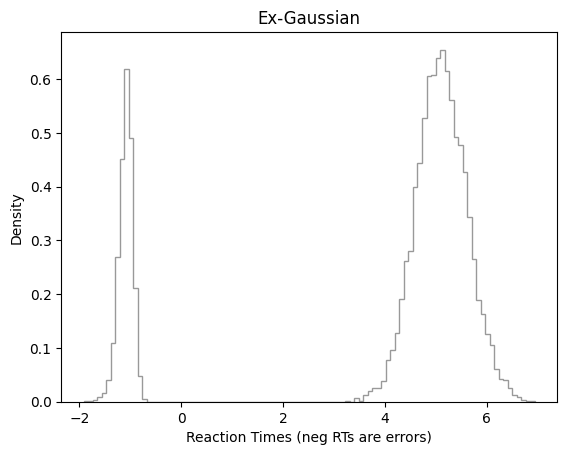

In [12]:
import matplotlib.pyplot as plt 
plt.hist(
    sim_out["rts"] * sim_out["choices"],
    bins=100,
    histtype="step",
    color="black",
    label="Weibull Deadline",
    density=True,
    alpha=0.4,
)
# s = choice*x
# idx = np.argsort(s) # sort the values so theyre not zig zaggy 
# plt.plot(s[idx], pdf_vals[idx], color="red", label="Ex-Gaussian Likelihood")
plt.xlabel("Reaction Times (neg RTs are errors)")
plt.ylabel("Density")
plt.title("Ex-Gaussian")


Text(0.5, 1.0, 'Ex-Gaussian Race')

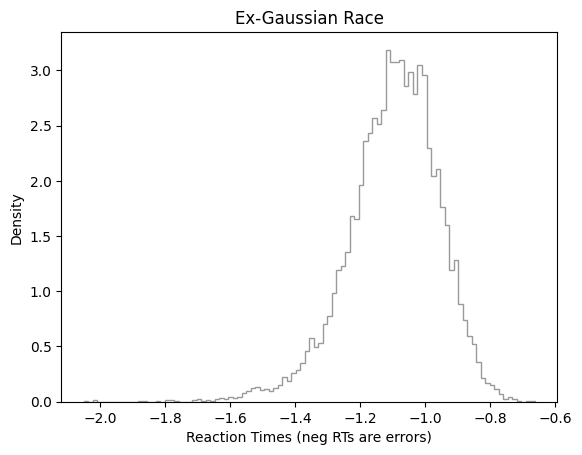

In [13]:
plt.hist(
    sim_out_race["rts"] * sim_out_race["choices"],
    bins=100,
    histtype="step",
    color="black",
    label="Weibull Deadline",
    density=True,
    alpha=0.4,
)
# s = choice*x
# idx = np.argsort(s) # sort the values so theyre not zig zaggy 
# plt.plot(s[idx], pdf_vals[idx], color="red", label="Ex-Gaussian Likelihood")
plt.xlabel("Reaction Times (neg RTs are errors)")
plt.ylabel("Density")
plt.title("Ex-Gaussian Race")

Text(0, 0.5, 'Density')

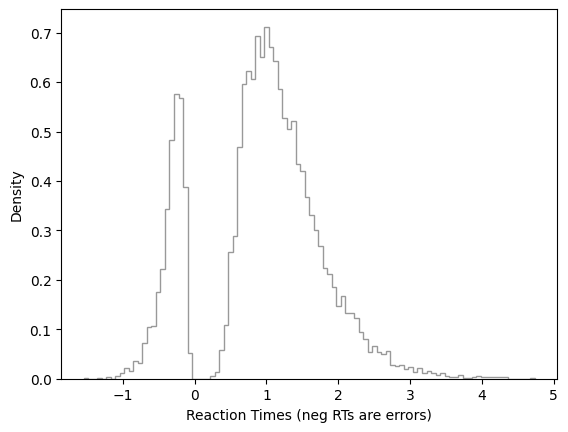

In [14]:
plt.hist(
    sim_out_2["rts"][sim_out_2["rts"] != -999] * sim_out_2["choices"][sim_out_2["rts"] != -999],
    bins=100,
    histtype="step",
    color="black",
    label="Weibull Deadline",
    density=True,
    alpha=0.4,
)
# s_sw = choice_sw*x_sw
# idx_sw = np.argsort(s_sw) # sort the values so theyre not zig zaggy
# plt.plot(s_sw[idx_sw], pdf_vals_sw[idx_sw], color="blue", label="Shifted Wald Likelihood")
plt.xlabel("Reaction Times (neg RTs are errors)")
plt.ylabel("Density")

Text(0, 0.5, 'Density')

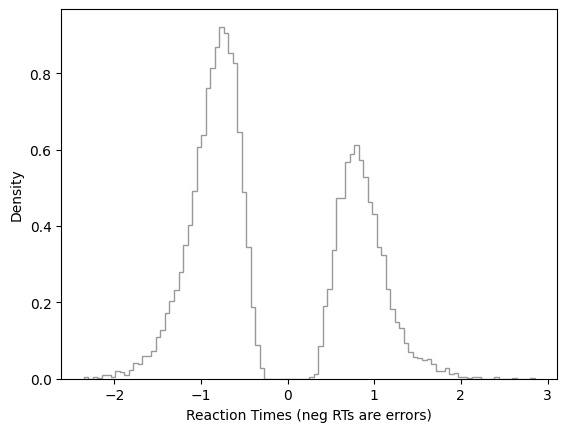

In [17]:
plt.hist(
    sim_out_2_race["rts"][sim_out_2_race["rts"] != -999] * sim_out_2_race["choices"][sim_out_2_race["rts"] != -999],
    bins=100,
    histtype="step",
    color="black",
    label="Weibull Deadline",
    density=True,
    alpha=0.4,
)
# s_sw = choice_sw*x_sw
# idx_sw = np.argsort(s_sw) # sort the values so theyre not zig zaggy
# plt.plot(s_sw[idx_sw], pdf_vals_sw[idx_sw], color="blue", label="Shifted Wald Likelihood")
plt.xlabel("Reaction Times (neg RTs are errors)")
plt.ylabel("Density")